In [ ]:
# default_exp core

# elec_consumption

Cluster analysis and statistical learning for electricity consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline
from elec_consumption.core import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.utils import check_equal_size, to_time_series_dataset

In [ ]:
#hide
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4 * 1.61803398875, 4]
_seed = 123  # for clustering analysis

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Introduction

There are 500 time series spanning 122 days (Aug 1, 2017 to Nov 30, 2017).

Preview first five rows for first five households. Unit is presumed to be kV.

In [ ]:
#hide_input
df.iloc[:5, :5]

household,0,1,2,3,4
datetime,,,,,
2017-08-01 00:00:00,0.094,0.028,0.116,0.096,0.189
2017-08-01 00:30:00,0.039,0.050,0.068,0.077,0.156
2017-08-01 01:00:00,0.088,0.060,0.044,0.095,0.118
2017-08-01 01:30:00,0.046,0.023,0.067,0.092,0.145
2017-08-01 02:00:00,0.082,0.020,0.068,0.085,0.153


Power consumption profiles of household 0, 1, 2 on Aug 1, 2017 are plotted:

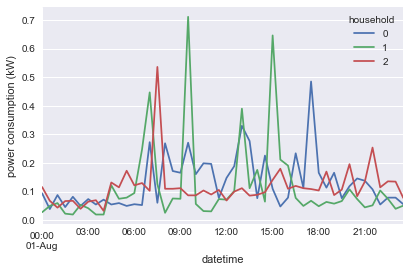

In [ ]:
#hide_input
df[df.index.date == datetime.date(2017, 8, 1)].iloc[:, :3].plot(
    ylabel='power consumption (kW)'
);

Aggregate profile of 0 hourly and compare two series:

In [ ]:
#hide
df_hour_0 = (
    df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0]
    .resample('1H', closed='left').mean().to_frame()
)
df_hour_0.columns = ['power']
df_hour_0['freq'] = 'hour'
df_hour_0.reset_index(inplace=True)
df_hour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_halfhour_0 = df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0].to_frame()
df_halfhour_0.columns = ['power']
df_halfhour_0['freq'] = 'half-hour'
df_halfhour_0.reset_index(inplace=True)
df_halfhour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_0 = pd.concat([df_hour_0, df_halfhour_0])

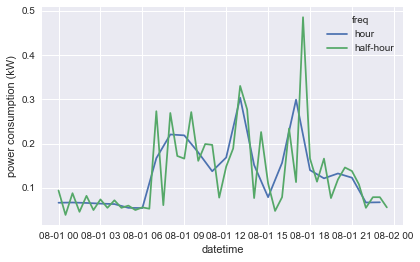

In [ ]:
#hide_input
ax = sns.lineplot(data=df_0, y='power', x='datetime', hue='freq')
ax.set(ylabel='power consumption (kW)');

Daily downsampled mean values of household 0 for the whole period:

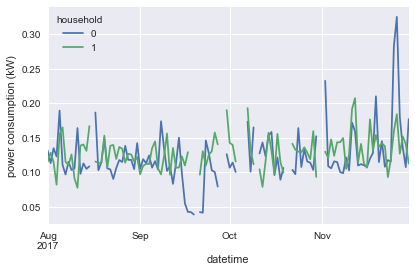

In [ ]:
#hide_input
df_daily = df.iloc[:, :2].resample('1D', closed='left').mean()
df_daily.plot(ylabel='power consumption (kW)');

### Handle Missing Entries

- For households 162, 428 and 432, two entries in different sets of dates are missed".
- For all the other households, 48 entries in different sets of dates are missed.


`NaN` values are filled with 0 for now.

In [ ]:
#hide
def get_list_dates_missing(df: DataFrame, household: int) -> DataFrame:
    """Find num of missing entries for every day.

    Args:
        df: original dataframe.
        household: integer index of given household.

    Return:
        Num of NaN per day.
    """
    num_nan_daily = (
        df.iloc[:, household].groupby(df.index.date)
        .apply(lambda x: x.isna().values.sum()).to_frame()
    )
    num_nan_daily.columns = ['num_nan_daily']
    return num_nan_daily[num_nan_daily['num_nan_daily'] > 0]

## 2. Cluster Analysis of Households

Households are to be clustered based on either hourly or daily consumption profiles.

In [ ]:
#hide
mts = to_time_series_dataset(df.fillna(0).T)
n_ts, max_sz, d = mts.shape

In [ ]:
assert (n_ts == 500 and max_sz == 5856 and d == 1)
assert check_equal_size(mts)

For example, assume there are 4 clusters.

In [ ]:
#hide
km = TimeSeriesKMeans(
    n_clusters=4, verbose=False, random_state=_seed)
clustered = km.fit_predict(mts)

In [ ]:
#hide
description = df.describe().T
description['cluster_id'] = clustered

In [ ]:
#hide_input
description.head(3)

,count,mean,std,min,25%,50%,75%,max,cluster_id
household,,,,,,,,,
0,5328.0,0.122169,0.135841,0.011,0.052,0.082,0.137,1.540,1
1,5280.0,0.128278,0.154372,0.010,0.043,0.075,0.144,1.479,1
2,5328.0,0.147232,0.093699,0.026,0.086,0.126,0.180,1.131,1


Sum of distances of samples to their closest cluster center:

In [ ]:
#hide_input
km.inertia_

275.74398859680036

In [ ]:
#hide
# for n_clusters in range(2, 20):
#     km = TimeSeriesKMeans(
#         n_clusters=4, verbose=False, random_state=_seed)
#     clustered = km.fit_predict(mts)

It takes a while to cluster using `KShape`.

In [ ]:
#hide
# ks = KShape(3, verbose=False)
# clustered_ks = ks.fit_predict(mts)
# description['cluster_id_ks'] = clustered_ks

## 3. Time Series Analysis

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.